## MCX simulation Stage 3.2 with multi-distance detector

In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to your folder containing the .py script
folder_path = '/content/drive/MyDrive/Colab Notebooks/MCX_Sims'

# Add to sys.path so you can import the script
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms
from FD_msNIRS import mcx_fft as mf
from FD_msNIRS import extract_freq as ef

In [4]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [6]:
g=0.85
wls = [670, 690, 705, 730, 750, 785, 808, 830]
ua = np.array([0.294514, 0.221244, 0.194485 , 0.186506, 0.2238,0.223521,0.234004,0.260758])  # cm-1
us_prime = [15.10252404, 14.40357034,13.91308298,13.15354804,12.59309117,11.70094737,11.16905272,10.69599611] # cm-1
us = np.array([x/(1-g) for x in us_prime])
distance = [2, 2.5, 3.0 ,3.5] # cm

In [7]:
us

array([100.6834936 ,  96.02380227,  92.75388653,  87.69032027,
        83.95394113,  78.0063158 ,  74.46035147,  71.30664073])

In [8]:
# compute ua, distance, and us in mm-1
ua_mm = ua/10
us_mm = us/10
distance_mm = [d*10 for d in distance]

In [9]:
ua_mm

array([0.0294514, 0.0221244, 0.0194485, 0.0186506, 0.02238  , 0.0223521,
       0.0234004, 0.0260758])

In [10]:
us_mm

array([10.06834936,  9.60238023,  9.27538865,  8.76903203,  8.39539411,
        7.80063158,  7.44603515,  7.13066407])

### Run simulations

In [11]:
dictt_ms={}
for j in range(ua_mm.shape[0]):
    print('ua = ', ua_mm[j])
    print('us = ', us_mm[j])
    TPSF_list, time_unit = ms(ua_mm[j], us_mm[j], g=0.85, n=1.370, distance=distance_mm, tend=1e-08, devf=1000, nphoton=1.2e8)

    for i, d in enumerate(distance_mm):
        label = f"{d}, {wls[j]}"
        dictt_ms[label] = [TPSF_list[i], time_unit]

ua =  0.0294514
us =  10.06834936
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0221244
us =  9.602380226666664
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0194485
us =  9.275388653333334
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0186506
us =  8.769032026666666
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.02238
us =  8.395394113333332
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0223521
us =  7.800631579999998
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08

In [12]:
print(len(dictt_ms))

32


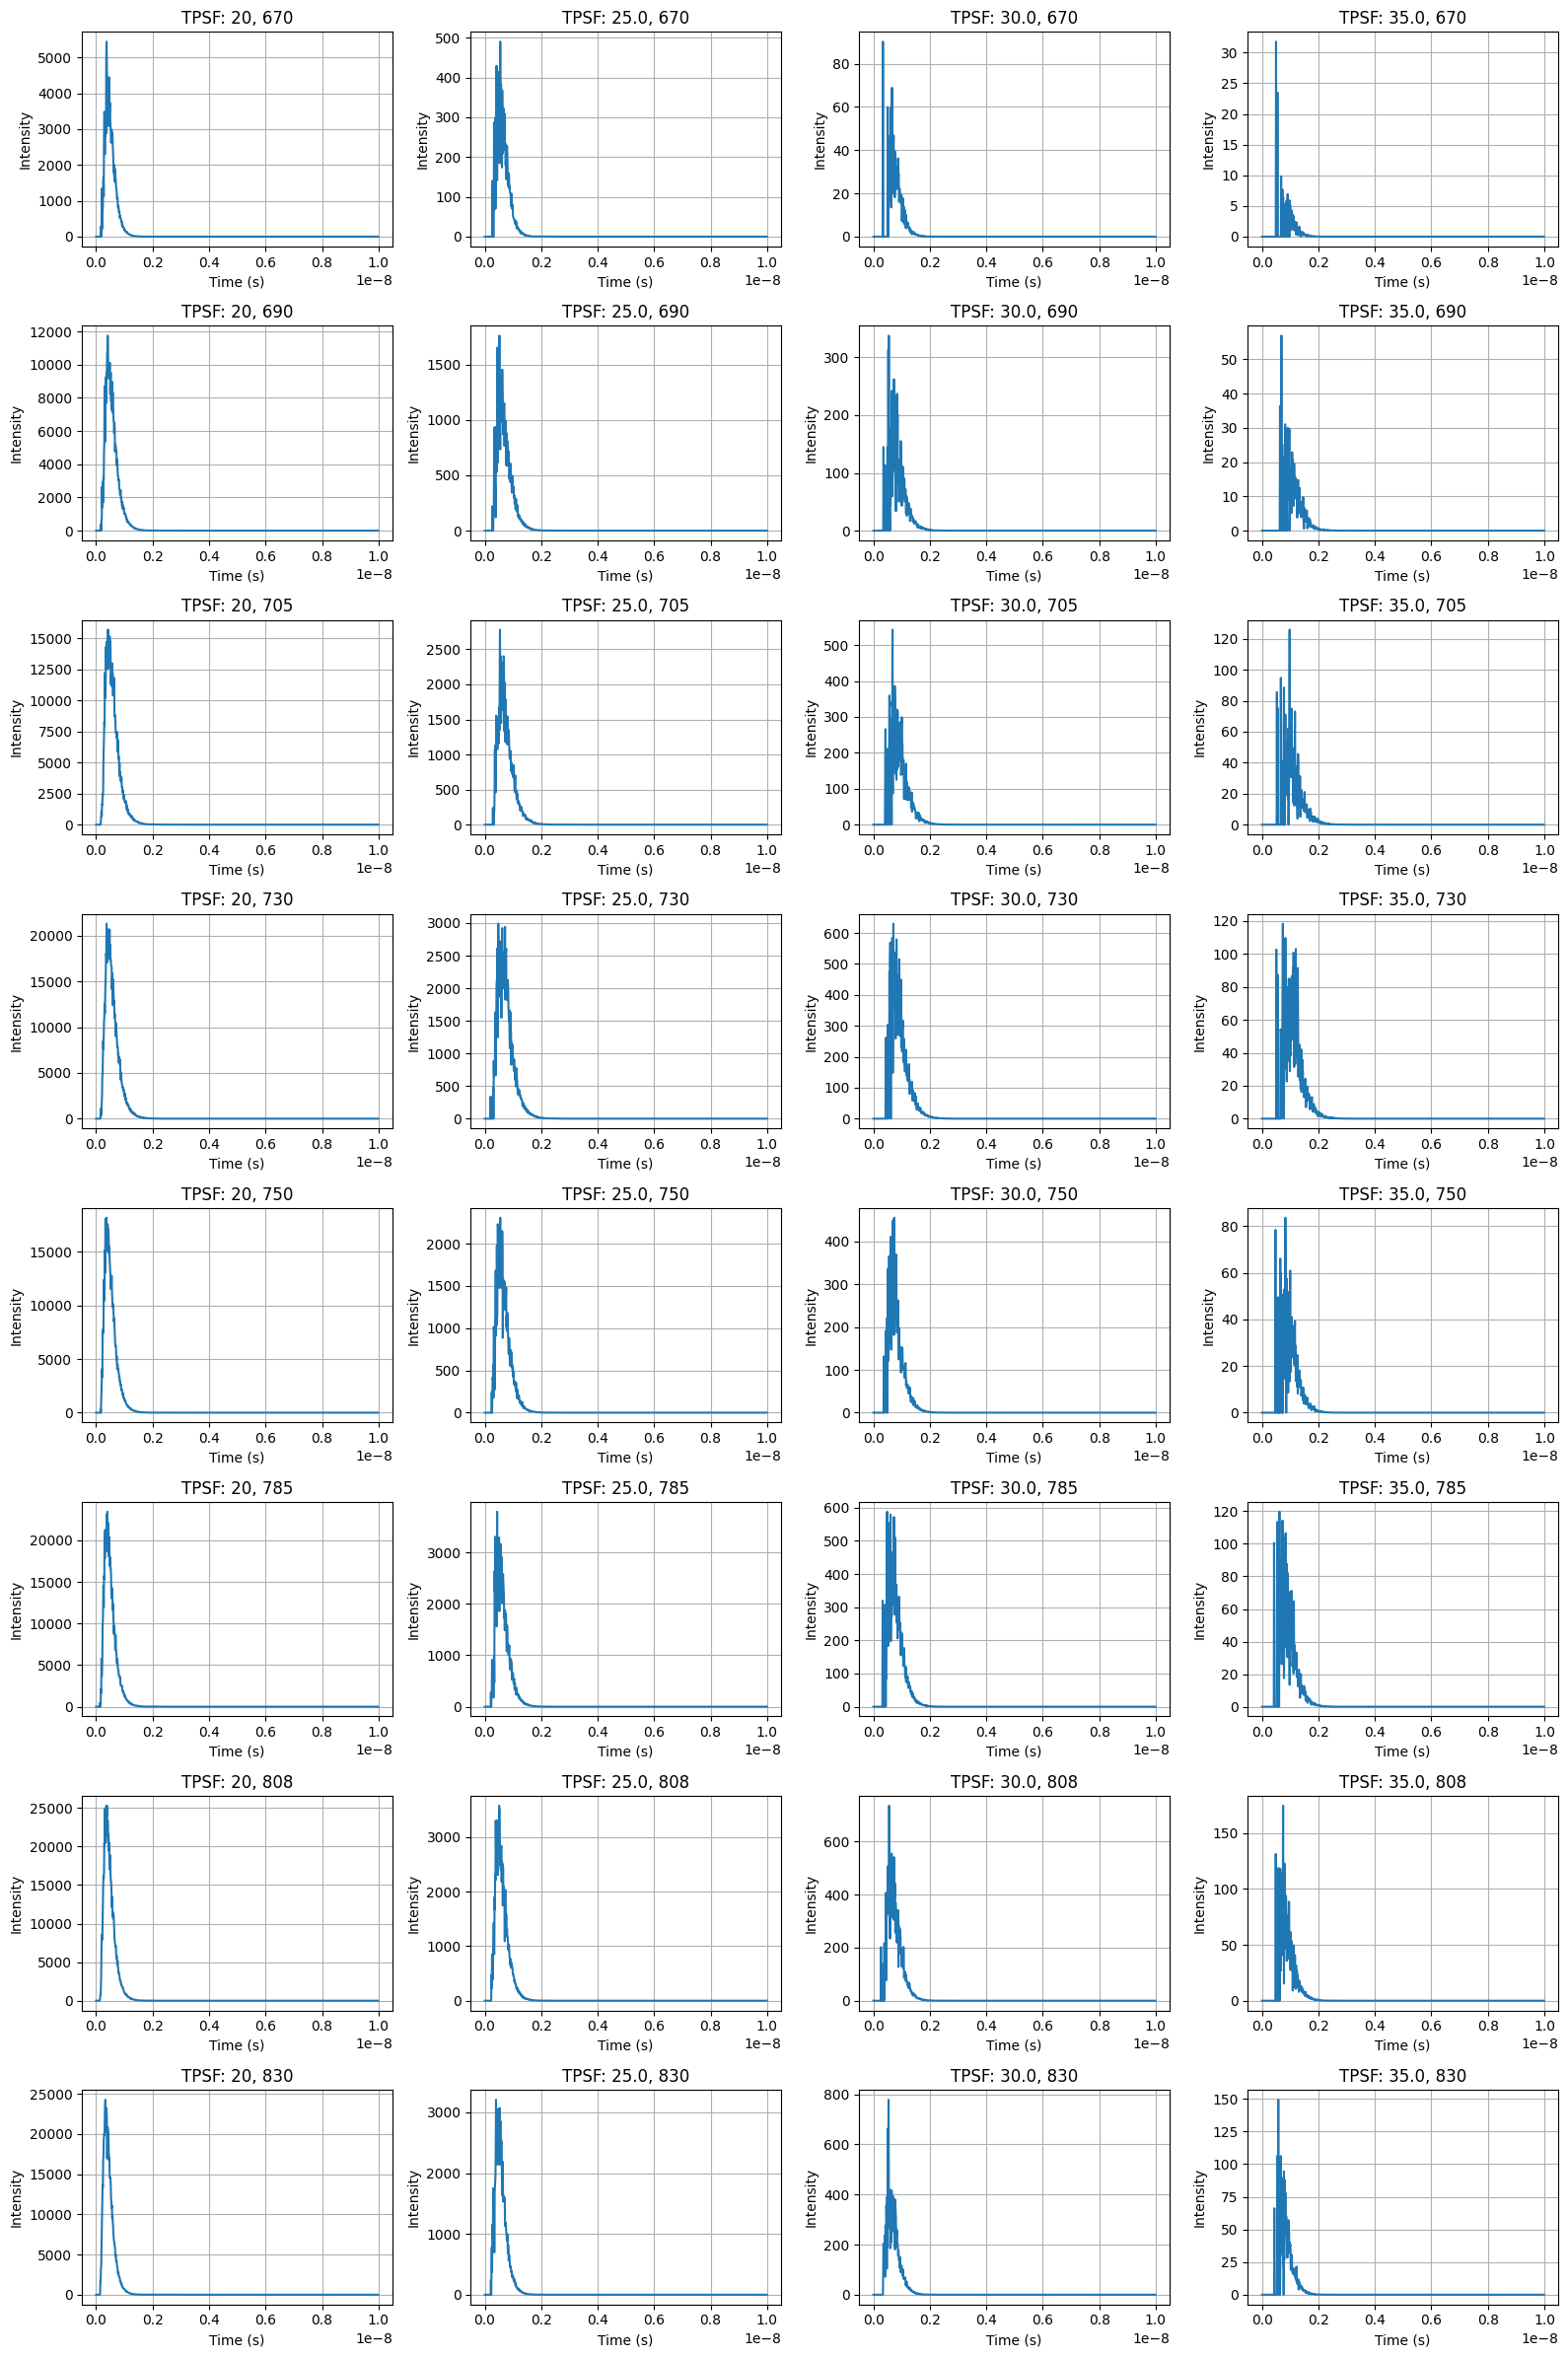

In [15]:
# --- Plotting ---

n_plots = len(dictt_ms)
cols = 4
rows = (n_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for idx, (label, (TPSF, time_unit)) in enumerate(dictt_ms.items()):
    t = np.arange(len(TPSF)) * time_unit
    axes[idx].plot(t, TPSF)
    axes[idx].set_title(f"TPSF: {label}")
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Intensity")
    axes[idx].grid(True)

# Remove extra axes if any
for i in range(n_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


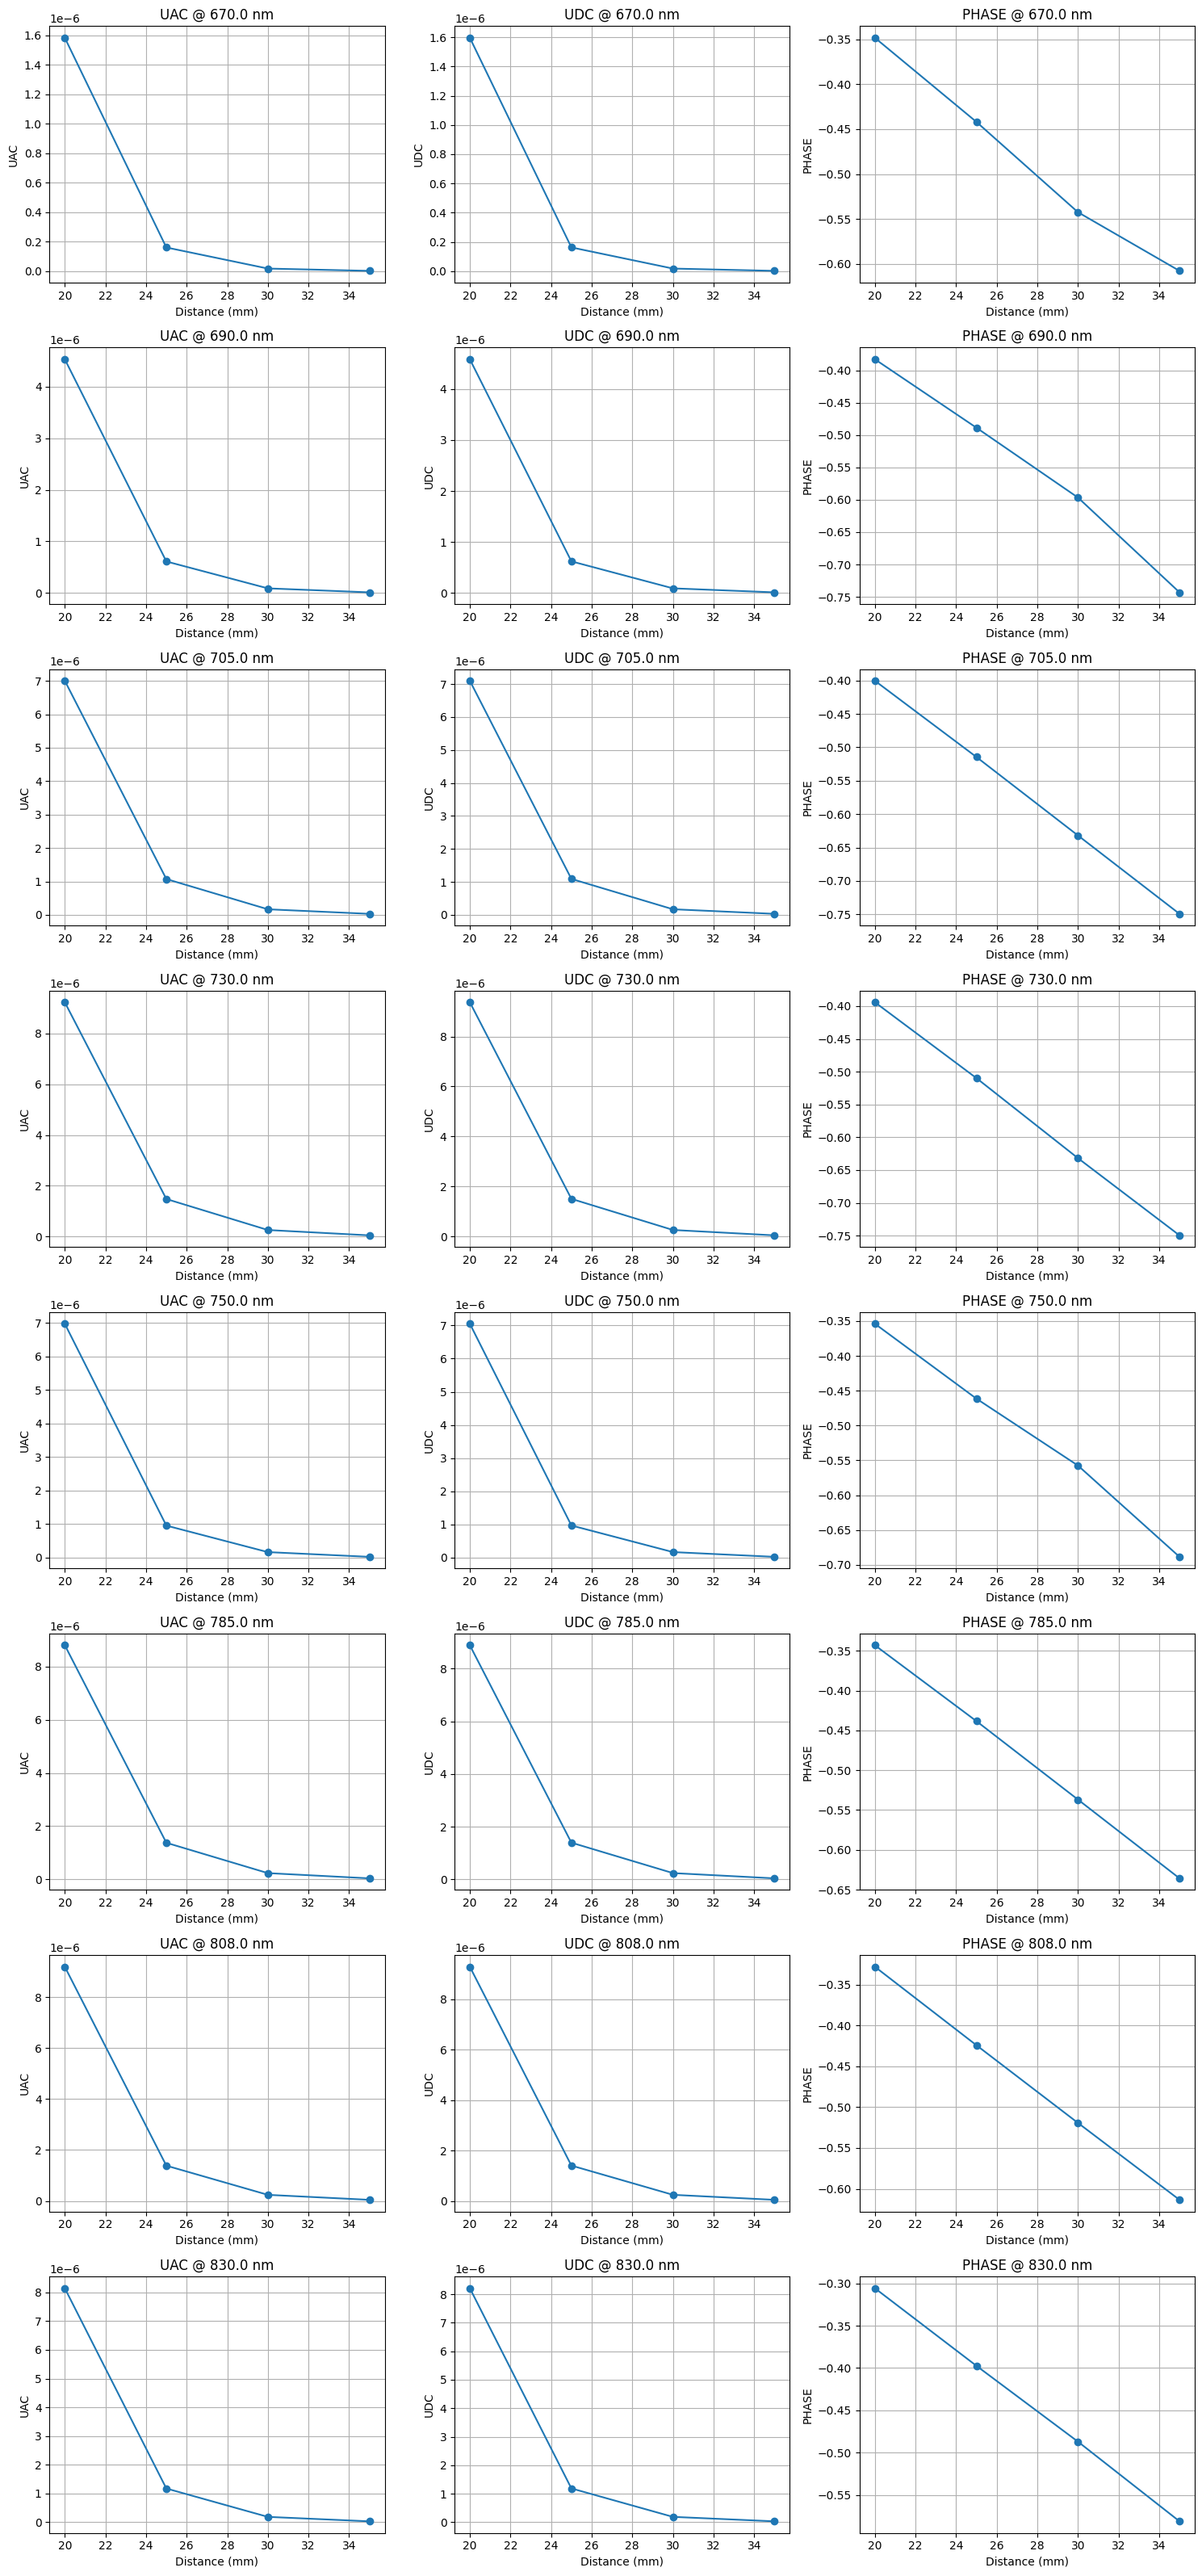

In [17]:
# --- Frequency domain analysis ---
target_freq = 110e6
uac = []
udc = []
phase1 = []
phase2 = []
labels = []

for label, (TPSF, tstep) in dictt_ms.items():
    uac_i, udc_i, p1, p2 = ef(target_freq, [TPSF], tend=1e-08, devf=1000)
    uac.append(uac_i[0])
    udc.append(udc_i[0])
    phase1.append(p1[0])
    phase2.append(p2[0])
    labels.append(label)
# Group data by wavelength
data_by_wl = {}

# Reconstruct the distances and wavelengths from the labels
for (key, (TPSF, tstep)), uac_i, udc_i, p1, p2 in zip(dictt_ms.items(), uac, udc, phase1, phase2):
    dist_str, wl_str = key.split(',')  # split key: "distance, wavelength"
    wl = float(wl_str.strip())
    d = float(dist_str.strip())

    if wl not in data_by_wl:
        data_by_wl[wl] = {'distance': [], 'uac': [], 'udc': [], 'phase': []}

    data_by_wl[wl]['distance'].append(d)
    data_by_wl[wl]['uac'].append(uac_i)
    data_by_wl[wl]['udc'].append(udc_i)
    data_by_wl[wl]['phase'].append(p1)

# Sort the wavelengths for consistent plotting
sorted_wls = sorted(data_by_wl.keys())

# Determine number of rows based on number of wavelengths
n_wl = len(sorted_wls)
cols = 3
rows = (n_wl + 1) if n_wl < 8 else n_wl  # ensure enough rows

# Prepare figure
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = np.array(axes).reshape(rows, cols)

metrics = ['uac', 'udc', 'phase']
titles = ['UAC', 'UDC', 'PHASE']

for row, wl in enumerate(sorted_wls):
    data = data_by_wl[wl]
    distances = data['distance']

    for col in range(cols):
        ax = axes[row, col]
        metric = metrics[col]
        ax.plot(distances, data[metric], marker='o')
        ax.set_title(f"{titles[col]} @ {wl} nm")
        ax.set_xlabel("Distance (mm)")
        ax.set_ylabel(titles[col])
        ax.grid(True)

# Remove unused subplots if any
for i in range(len(sorted_wls), rows):
    for j in range(cols):
        fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd

columns = []
row = []

# Get sorted lists to ensure consistent ordering
sorted_wls = sorted(data_by_wl.keys())
sorted_distances = sorted({d for data in data_by_wl.values() for d in data['distance']})

for i, distance in enumerate(sorted_distances):  # i = distance index
    for j, wl in enumerate(sorted_wls):         # j = wavelength index
        data = data_by_wl[wl]
        if distance in data['distance']:
            idx = data['distance'].index(distance)

            # Use index-based naming like U_AC_1_1
            columns.extend([
                f"U_AC_{i+1}_{j+1}",
                f"U_DC_{i+1}_{j+1}",
                f"Phase_{i+1}_{j+1}"
            ])

            row.extend([
                data['uac'][idx],
                data['udc'][idx],
                data['phase'][idx]
            ])

df = pd.DataFrame([row], columns=columns)
df.to_csv("stage3_2.csv", index=False)
